# AI Movie Recomender system
## AI แนะนำหนังจากความชอบส่วนตัวของผู้ใช้
## Wisarut Duangmorakot - wisarut.bank@gmail.com 

ในปัจจุบันจะเห็นได้ว่าบริษัทใหญ่ๆในโลกอย่าง Netflix, Amazon หรือ Youtube มียอดขายหรือยอดคนดูที่เพิ่มขึ้น ซึ่งส่วนหนึ่งมาจากการใช้ Recomender system ในการแนะนำสินค้าหรือหนัง เพื่อให้ถูกใจคนดูแต่ละคน  <br> ซึ่งในที่นี้เราจะนำเอา Recomender system มาใช้ในการแนะนำหนังที่ไม่เคยดูให้กับตัวเองโดยใช้ข้อมูลจากการดูหนังของเราในอดีตและการ rating ของ user คนอื่นที่อาจจะมีรสนิยมดูหนังที่คล้ายกันกับเรา

## Datasets
#### จาก MovieLens https://grouplens.org/datasets/movielens/ (This notebook used small datasets)
Small: 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Read File 

#### หลังจาก Extract zip จะได้ไฟล์ทั้งหมด 4 ไฟล์

In [2]:
links = pd.read_csv('./ml-latest-small/links.csv')
movie = pd.read_csv('./ml-latest-small/movies.csv')
ratings = pd.read_csv('./ml-latest-small/ratings.csv')
tags = pd.read_csv('./ml-latest-small/tags.csv')

In [3]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


ไฟล์ links.csv ใช้เพื่ออ้างถึงรหัสของหนังกับ link ของหนังในเว็บไซต์ imdb ซึ่งเราจะไม่เอาไฟล์นี้มาใช้ในการสร้างโมเดล

In [4]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


ไฟล์ movies.csv บอกถึง รหัสของหนัง, ชื่อ และประเภทของหนัง

In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


ratings.csv เป็นไฟล์ที่สำคัญ เพราะไฟล์นี้บอกถึงการ rating หนังที่ผ่านมาของ user แต่ละ user ซึ่งเราจะเอา rating นี้ไปสร้างโมเดล เพื่อหา user ที่มีรสนิยมการดูหนังที่คล้ายกับเรา

In [6]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


tags.csv บอกถึงว่าหนังแต่ละเรื่องมีการ tag อะไรบ้าง ซึ่งเราจะไม่นำส่วนนี้มาพิจารณาในการสร้างโมเดล

### Data preprocessing

เราต้องการ Matrix ที่จะนำไปทำ Recommender system ดังนี้
<pre>
         |ประเภทของหนัง1|ประเภทของหนัง...|ประเภทของหนัง n| userRating1|userRating...|userRating n| myRating|
movie1   |            |               |             |             |             |           |          |
movie... |            |               |             |             |             |           |          |
movie n  |            |               |             |             |             |           |          |
</pre>

### ส่วนของ movie.csv

In [7]:
movie.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


มีหนังทั้งสิ้น 9742 เรื่อง

In [8]:
movie_matrix = movie.copy() #Duplicate ตัวแปร movie ไว้เผื่อจะต้องนำกลับมาใช้

In [9]:
cateDummies = movie['genres'].apply(lambda x: x.split('|'))
cateDummies
#แยกหมวดหมู่ที่คั่นด้วย '|' ออกมาเป็น list (Adventure|Animation|Children|Comedy|Fantasy) -> [Adventure, 
#Animation, Children, Comedy, Fantasy]

0       [Adventure, Animation, Children, Comedy, Fantasy]
1                          [Adventure, Children, Fantasy]
2                                       [Comedy, Romance]
3                                [Comedy, Drama, Romance]
4                                                [Comedy]
5                               [Action, Crime, Thriller]
6                                       [Comedy, Romance]
7                                   [Adventure, Children]
8                                                [Action]
9                           [Action, Adventure, Thriller]
10                               [Comedy, Drama, Romance]
11                                       [Comedy, Horror]
12                       [Adventure, Animation, Children]
13                                                [Drama]
14                           [Action, Adventure, Romance]
15                                         [Crime, Drama]
16                                       [Drama, Romance]
17            

In [10]:
movie_matrix['Action'] = 0
movie_matrix['Adventure'] = 0
movie_matrix['Animation'] = 0
movie_matrix["Children's"] = 0
movie_matrix['Comedy'] = 0
movie_matrix['Crime'] = 0
movie_matrix['Documentary'] = 0
movie_matrix['Drama'] = 0
movie_matrix['Fantasy'] = 0
movie_matrix['Film-Noir'] = 0
movie_matrix['Horror'] = 0
movie_matrix['Musical'] = 0
movie_matrix['Mystery'] = 0
movie_matrix['Romance'] = 0
movie_matrix['Sci-Fi'] = 0
movie_matrix['Thriller'] = 0
movie_matrix['War'] = 0
movie_matrix['Western'] = 0

In [11]:
# สร้าง Columns เพิ่มขึ้นมา 18 columns เพื่อรองรับประเภทของหนังจาก category ที่เราได้มา

In [12]:
category = np.zeros((len(movie), 18)) #สร้าง numpy array เพื่อรองรับการเอาประเภทของหนังใส่ใน Columns ซึ่งการใช้ numpy array 
#จะทำให้เร็วกว่าการนำไป operate กับ pandas โดยตรง

for i in range(len(cateDummies)):  # วน Loop จนกระทั่งถึงตัวสุดท้ายของ CateDummies
    if "Action" in cateDummies[i]: # เช็คว่ามีคำว่า Action อยู่ใน list cateDummies หรือไม่
        category[i][0] = 1         # ถ้ามีให้ category ที่เป็น numpy array ช่องที่ 1 เป็น 1

    if "Adventure" in cateDummies[i]:
        category[i][1] = 1
    
    if "Animation" in cateDummies[i]:
        category[i][2] = 1
        
    if "Children's" in cateDummies[i]:
        category[i][3] = 1
        
    if "Comedy" in cateDummies[i]:
        category[i][4] = 1
        
    if "Crime" in cateDummies[i]:
        category[i][5] = 1
        
    if "Documentary" in cateDummies[i]:
        category[i][6] = 1
        
    if "Drama" in cateDummies[i]:
        category[i][7] = 1
        
    if "Fantasy" in cateDummies[i]:
        category[i][8] = 1
        
    if "Film-Noir" in cateDummies[i]:
        category[i][9] = 1
        
    if "Horror" in cateDummies[i]:
        category[i][10] = 1
        
    if "Musical" in cateDummies[i]:
        category[i][11] = 1
        
    if "Mystery" in cateDummies[i]:
        category[i][12] = 1
        
    if "Romance" in cateDummies[i]:
        category[i][13] = 1
        
    if "Sci-Fi" in cateDummies[i]:
        category[i][14] = 1
        
    if "Thriller" in cateDummies[i]:
        category[i][15] = 1
        
    if "War" in cateDummies[i]:
        category[i][16] = 1
        
    if "Western" in cateDummies[i]:
        category[i][17] = 1

In [13]:
category #ได้ numpy array ที่บอกถึงหมวดหมู่หนัง 

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
movie_matrix.columns #แสดงชื่อ Columns ของ movie_matrix

Index([u'movieId', u'title', u'genres', u'Action', u'Adventure', u'Animation',
       u'Children's', u'Comedy', u'Crime', u'Documentary', u'Drama',
       u'Fantasy', u'Film-Noir', u'Horror', u'Musical', u'Mystery', u'Romance',
       u'Sci-Fi', u'Thriller', u'War', u'Western'],
      dtype='object')

In [15]:
movie_matrix[movie_matrix.columns[3:]] = category # นำหมวดหมู่หนังใส่เข้าไปใน movie_matrix

In [16]:
movie_matrix.drop(columns=['genres'],inplace=True) #drop columns genres ทิ้ง
movie_matrix.head()

,movieId,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### ส่วนของ Ratings

In [17]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [18]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [19]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


มีทั้งหมด 610 users

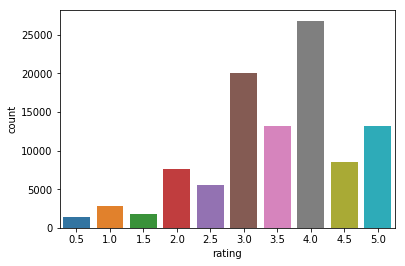

In [20]:
sns.countplot(ratings['rating'])
plt.show()

rating ที่ users กรอกไว้ มีตั้งแต่ 0.5 ถึง 5.0 เพิ่มขึ้นทีละ 0.5

In [21]:
for i in range(len(ratings.groupby(['userId']).count())):
    movie_matrix['u'+str(i+1)] = 0

สร้าง Columns 'u1' ถึง 'u610' 

In [22]:
movie_matrix

,movieId,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,u601,u602,u603,u604,u605,u606,u607,u608,u609,u610
0,1,Toy Story (1995),0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5,6,Heat (1995),1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6,7,Sabrina (1995),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,8,Tom and Huck (1995),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8,9,Sudden Death (1995),1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9,10,GoldenEye (1995),1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
score_matrix = np.zeros((len(movie), len(ratings.groupby(['userId']).count())))
score_matrix.shape

(9742, 610)

สร้าง matrix ขนาด 6742 x 610 เพื่อเก็บ data การ rating ของ user

In [24]:
mov = movie_matrix.copy() #duplicate ตัวแปร
mov['num'] = range(0,len(mov)) #สร้าง columns num ซึ่งมีค่าเพิ่มขึ้นทีละ 1 ในแต่ละ rows
mov.set_index('movieId', inplace=True) #set movieId เป็น index ของ pandas 
dictMovieId = mov['num'].to_dict() #สร้างตัวแปร dict เพื่อ refer ถึง index หนังจริงๆได้

สร้าง variable type dict เพื่อให้สามารถใช้ movieId refer ถึง index ได้ เนื่องจาก movieId ไม่ได้เรียงจาก 1 ถึง n

In [25]:
for i in range(len(ratings)):
    score_matrix[dictMovieId[ratings['movieId'].loc[i]]][ratings['userId'].loc[i]-1] = ratings['rating'].loc[i]

วน For loop สร้าง score_matrix ที่เก็บ user rating ไว้

In [26]:
score_matrix

array([[4. , 0. , 0. , ..., 2.5, 3. , 5. ],
       [0. , 0. , 0. , ..., 2. , 0. , 0. ],
       [4. , 0. , 0. , ..., 2. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [27]:
movie_matrix[movie_matrix.columns[20:]] = score_matrix

นำค่าของ score matrix เก็บเข้าไปไว้ในตัวแปร movie_matrix 

In [28]:
movie_matrix # Movie_matrix

,movieId,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,u601,u602,u603,u604,u605,u606,u607,u608,u609,u610
0,1,Toy Story (1995),0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,2,Jumanji (1995),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,3,Grumpier Old Men (1995),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,4,Waiting to Exhale (1995),0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,Heat (1995),1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0
6,7,Sabrina (1995),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0
7,8,Tom and Huck (1995),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,Sudden Death (1995),1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,GoldenEye (1995),1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0


จะเห็นได้ว่าเราเกือบได้ Matrix ที่ต้องการแล้วขาดแค่ myRating
<pre>
         |ประเภทของหนัง1|ประเภทของหนัง...|ประเภทของหนัง n| userRating1|userRating...|userRating n| myRating|
movie1   |            |               |             |             |             |           |          |
movie... |            |               |             |             |             |           |          |
movie n  |            |               |             |             |             |           |          |
</pre>

## Features Engineering

In [29]:
movie_matrix.dtypes #check type ของตัวแปร

movieId          int64
title           object
Action         float64
Adventure      float64
Animation      float64
Children's     float64
Comedy         float64
Crime          float64
Documentary    float64
Drama          float64
Fantasy        float64
Film-Noir      float64
Horror         float64
Musical        float64
Mystery        float64
Romance        float64
Sci-Fi         float64
Thriller       float64
War            float64
Western        float64
u1             float64
u2             float64
u3             float64
u4             float64
u5             float64
u6             float64
u7             float64
u8             float64
u9             float64
u10            float64
                ...   
u581           float64
u582           float64
u583           float64
u584           float64
u585           float64
u586           float64
u587           float64
u588           float64
u589           float64
u590           float64
u591           float64
u592           float64
u593       

In [30]:
movie_matrix[movie_matrix.columns[2:20]] = movie_matrix[movie_matrix.columns[2:20]].astype('category')
movie_matrix[movie_matrix.columns[20:]] = movie_matrix[movie_matrix.columns[20:]].astype('float')

เปลี่ยน Type ของตัวแปรที่ต้องการ ประเภทของหนังเป็น categorical, user rating เป็น float

In [31]:
movie_matrix

,movieId,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,u601,u602,u603,u604,u605,u606,u607,u608,u609,u610
0,1,Toy Story (1995),0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,2,Jumanji (1995),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,3,Grumpier Old Men (1995),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,4,Waiting to Exhale (1995),0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,Heat (1995),1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0
6,7,Sabrina (1995),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0
7,8,Tom and Huck (1995),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,Sudden Death (1995),1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,GoldenEye (1995),1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0


In [32]:
mov = movie_matrix.copy()
mov['num'] = range(0,len(mov))
mov.set_index('title', inplace=True)
dictTitle = mov['num'].to_dict()

สร้าง ตัวแปรประเภท dict เพื่อให้ ชื่อของหนังสามารถ refer ถึง index ได้

In [33]:
dictTitle

{'Family, The (2013)': 8259,
 'Ladykillers, The (1955)': 3971,
 'Little Big League (1994)': 494,
 'Times of Harvey Milk, The (1984)': 5519,
 'Extreme Days (2001)': 3526,
 'Chairman of the Board (1998)': 1264,
 'Contender, The (2000)': 2948,
 'Predestination (2014)': 8533,
 'Night of the Shooting Stars (Notte di San Lorenzo, La) (1982)': 4213,
 'Wallace & Gromit in The Curse of the Were-Rabbit (2005)': 6015,
 'Panic Room (2002)': 3770,
 'Exorcist, The (1973)': 1472,
 'Sabotage (1936)': 1656,
 'Tin Men (1987)': 1075,
 'Quigley Down Under (1990)': 5568,
 'True Story (2015)': 8736,
 'Mulan II (2004)': 8418,
 'The Wild One (1953)': 5441,
 'Cornered! (2009)': 9061,
 'Legend (2015)': 9041,
 'Eight Men Out (1988)': 3203,
 'Monument Ave. (1998)': 1696,
 'Icarus (2017)': 9609,
 'Twin Peaks: Fire Walk with Me (1992)': 2449,
 'Northfork (2003)': 4431,
 '2 Days in the Valley (1996)': 760,
 'Book Thief, The (2013)': 8294,
 'Deep Impact (1998)': 1371,
 'Gonzo: The Life and Work of Dr. Hunter S. Thomp

เช่นเมื่อเราใส่ dictTitle['Family, The (2013)'] จะได้ค่า 8259 ที่เป็น index ใน movie_matrix return ออกมา

In [34]:
movie_matrix['y'] = -1 #สร้าง Columns myrating แทนด้วย y

แทนค่าใน column y ใส่ค่า -1 แทนหนังที่ไม่เคยดู และหนังเรื่องไหนที่เคยดูเราจะแทนด้วยความชอบของเรา เช่นหนังที่ได้ 5 คือหนังที่เราชอบมาก หนังที่ได้ 1 คือหนังที่เราไม่ชอบเลย ซึ่งอาจจะทำได้ไม่ครบทุกเรื่องเนื่องจากมีจำนวนที่เยอะ

In [35]:
movie_matrix['y'].iloc[dictTitle["Toy Story (1995)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Mission: Impossible - Fallout (2018)"]] = 4
movie_matrix['y'].iloc[dictTitle["Ant-Man and the Wasp (2018)"]] = 4
movie_matrix['y'].iloc[dictTitle["Solo: A Star Wars Story (2018)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Deadpool 2 (2018)"]] = 5
movie_matrix['y'].iloc[dictTitle["Incredibles 2 (2018)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Jurassic World: Fallen Kingdom (2018)"]] = 4
movie_matrix['y'].iloc[dictTitle["Maze Runner: The Death Cure (2018)"]] = 4
movie_matrix['y'].iloc[dictTitle["Star Wars: The Last Jedi (2017)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Paddington 2 (2017)"]] = 3
movie_matrix['y'].iloc[dictTitle["Kingsman: The Golden Circle (2017)"]] = 4
movie_matrix['y'].iloc[dictTitle["Passengers (2016)"]] = 4
movie_matrix['y'].iloc[dictTitle["Rogue One: A Star Wars Story (2016)"]] = 4
movie_matrix['y'].iloc[dictTitle["Inferno (2016)"]] = 3
movie_matrix['y'].iloc[dictTitle["The Accountant (2016)"]] = 2.5
movie_matrix['y'].iloc[dictTitle["Miss Peregrine's Home for Peculiar Children (2016)"]] = 2
movie_matrix['y'].iloc[dictTitle["Ice Age: Collision Course (2016)"]] = 3
movie_matrix['y'].iloc[dictTitle["Now You See Me 2 (2016)"]] = 4
movie_matrix['y'].iloc[dictTitle["Snowden (2016)"]] = 1.5
movie_matrix['y'].iloc[dictTitle["Ice Age: The Great Egg-Scapade (2016)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Zootopia (2016)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["The Intern (2015)"]] = 4
movie_matrix['y'].iloc[dictTitle["The Jungle Book (2016)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Batman v Superman: Dawn of Justice (2016)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Steve Jobs (2015)"]] = 3
movie_matrix['y'].iloc[dictTitle["Kung Fu Panda: Secrets of the Masters (2011)"]] = 4.5
movie_matrix['y'].iloc[dictTitle["Spectre (2015)"]] = 4
movie_matrix['y'].iloc[dictTitle["Minions (2015)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Ted 2 (2015)"]] = 3
movie_matrix['y'].iloc[dictTitle["Star Trek Beyond (2016)"]] = 5
movie_matrix['y'].iloc[dictTitle["Suicide Squad (2016)"]] = 4
movie_matrix['y'].iloc[dictTitle["The Secret Life of Pets (2016)"]] = 4
movie_matrix['y'].iloc[dictTitle["Fantastic Beasts and Where to Find Them (2016)"]] = 4
movie_matrix['y'].iloc[dictTitle["The Hunger Games: Mockingjay - Part 2 (2015)"]] = 5
movie_matrix['y'].iloc[dictTitle["Inside Out (2015)"]] = 5
movie_matrix['y'].iloc[dictTitle["Pitch Perfect 2 (2015)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Furious 7 (2015)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Cinderella (2015)"]] = 4.5
movie_matrix['y'].iloc[dictTitle["Thor: Ragnarok (2017)"]] = 4
movie_matrix['y'].iloc[dictTitle["Guardians of the Galaxy 2 (2017)"]] = 4.5
movie_matrix['y'].iloc[dictTitle["Captain America: Civil War (2016)"]] = 5
movie_matrix['y'].iloc[dictTitle["Doctor Strange (2016)"]] = 4.5
movie_matrix['y'].iloc[dictTitle["X-Men: Apocalypse (2016)"]] = 4
movie_matrix['y'].iloc[dictTitle["Avengers: Infinity War - Part I (2018)"]] = 5
movie_matrix['y'].iloc[dictTitle["Black Panther (2017)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Deadpool (2016)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Fantastic Four (2015)"]] = 3
movie_matrix['y'].iloc[dictTitle["Ant-Man (2015)"]] = 4
movie_matrix['y'].iloc[dictTitle["Justice League (2017)"]] = 3
movie_matrix['y'].iloc[dictTitle["Pirates of the Caribbean: Dead Men Tell No Tales (2017)"]] = 4
movie_matrix['y'].iloc[dictTitle["Avengers: Age of Ultron (2015)"]] = 4.5
movie_matrix['y'].iloc[dictTitle["Star Wars: Episode VII - The Force Awakens (2015)"]] = 4.5
movie_matrix['y'].iloc[dictTitle["Mad Max: Fury Road (2015)"]] = 2.5
movie_matrix['y'].iloc[dictTitle["Kingsman: The Secret Service (2015)"]] = 4
movie_matrix['y'].iloc[dictTitle["Into the Woods (2014)"]] = 4
movie_matrix['y'].iloc[dictTitle["Ice Age: A Mammoth Christmas (2011)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Maze Runner: Scorch Trials (2015)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Paddington (2014)"]] = 3
movie_matrix['y'].iloc[dictTitle["Exodus: Gods and Kings (2014)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["The Imitation Game (2014)"]] = 4
movie_matrix['y'].iloc[dictTitle["John Wick (2014)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Predestination (2014)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Maze Runner, The (2014)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Guardians of the Galaxy (2014)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Transformers: Age of Extinction (2014)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Tangled Ever After (2012)"]] = 4.5
movie_matrix['y'].iloc[dictTitle["Mission: Impossible - Rogue Nation (2015)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Edge of Tomorrow (2014)"]] = 4.5
movie_matrix['y'].iloc[dictTitle["Maleficent (2014)"]] = 4
movie_matrix['y'].iloc[dictTitle["X-Men: Days of Future Past (2014)"]] = 4
movie_matrix['y'].iloc[dictTitle["Godzilla (2014)"]] = 2.5
movie_matrix['y'].iloc[dictTitle["Puss in Boots: The Three Diablos (2012)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Interstellar (2014)"]] = 5
movie_matrix['y'].iloc[dictTitle["Frozen (2013)"]] = 4
movie_matrix['y'].iloc[dictTitle["Hobbit: The Desolation of Smaug, The (2013)"]] = 2.5
movie_matrix['y'].iloc[dictTitle["The Hunger Games: Catching Fire (2013)"]] = 4
movie_matrix['y'].iloc[dictTitle["Thor: The Dark World (2013)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Ender's Game (2013)"]] = 3
movie_matrix['y'].iloc[dictTitle["The Hunger Games: Mockingjay - Part 1 (2014)"]] = 5
movie_matrix['y'].iloc[dictTitle["Captain Phillips (2013)"]] = 1.5
movie_matrix['y'].iloc[dictTitle["Despicable Me 2 (2013)"]] = 3
movie_matrix['y'].iloc[dictTitle["Elysium (2013)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Pacific Rim (2013)"]] = 2.5
movie_matrix['y'].iloc[dictTitle["Monsters University (2013)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Man of Steel (2013)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Now You See Me (2013)"]] = 4
movie_matrix['y'].iloc[dictTitle["Star Trek Into Darkness (2013)"]] = 4.5
movie_matrix['y'].iloc[dictTitle["Iron Man 3 (2013)"]] = 5
movie_matrix['y'].iloc[dictTitle["Taken 2 (2012)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Looper (2012)"]] = 4
movie_matrix['y'].iloc[dictTitle["Pitch Perfect (2012)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Ice Age 4: Continental Drift (2012)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Ted (2012)"]] = 3
movie_matrix['y'].iloc[dictTitle["Madagascar 3: Europe's Most Wanted (2012)"]] = 4
movie_matrix['y'].iloc[dictTitle["Snow White and the Huntsman (2012)"]] = 4
movie_matrix['y'].iloc[dictTitle["Men in Black III (M.III.B.) (M.I.B.³) (2012)"]] = 4
movie_matrix['y'].iloc[dictTitle["Battleship (2012)"]] = 4
movie_matrix['y'].iloc[dictTitle["Mirror Mirror (2012)"]] = 4
movie_matrix['y'].iloc[dictTitle["This Means War (2012)"]] = 4
movie_matrix['y'].iloc[dictTitle["Mission: Impossible - Ghost Protocol (2011)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Inception (2010)"]] = 4
movie_matrix['y'].iloc[dictTitle["Harry Potter and the Goblet of Fire (2005)"]] = 4
movie_matrix['y'].iloc[dictTitle["Inception (2010)"]] = 4
movie_matrix['y'].iloc[dictTitle["Cast Away (2000)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Inception (2010)"]] = 4
movie_matrix['y'].iloc[dictTitle["Forrest Gump (1994)"]] = 4
movie_matrix['y'].iloc[dictTitle["Harry Potter and the Deathly Hallows: Part 1 (2010)"]] = 4
movie_matrix['y'].iloc[dictTitle["Harry Potter and the Deathly Hallows: Part 2 (2011)"]] = 4.5
movie_matrix['y'].iloc[dictTitle["Tangled (2010)"]] = 5
movie_matrix['y'].iloc[dictTitle["Lord of the Rings, The (1978)"]] = 2
movie_matrix['y'].iloc[dictTitle["Ratatouille (2007)"]] = 4.5
movie_matrix['y'].iloc[dictTitle["WALL·E (2008)"]] = 4.5
movie_matrix['y'].iloc[dictTitle["Avengers, The (2012)"]] = 4.5
movie_matrix['y'].iloc[dictTitle["Captain America: The Winter Soldier (2014)"]] = 4.5
movie_matrix['y'].iloc[dictTitle["Thor (2011)"]] = 3.5
movie_matrix['y'].iloc[dictTitle["Avengers, The (2012)"]] = 4.5
movie_matrix['y'].iloc[dictTitle["Kung Fu Panda 2 (2011)"]] = 4
movie_matrix['y'].iloc[dictTitle["Arrival (2016)"]] = 4.5
movie_matrix['y'].iloc[dictTitle["The Martian (2015)"]] = 5

movie_matrix['y'] = movie_matrix['y'].astype('float')

/home/bank/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


แทนค่าใน y ได้ดังนี้

In [36]:
movie_matrix

,movieId,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,u602,u603,u604,u605,u606,u607,u608,u609,u610,y
0,1,Toy Story (1995),0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0,3.5
1,2,Jumanji (1995),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0,-1.0
2,3,Grumpier Old Men (1995),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,-1.0
3,4,Waiting to Exhale (1995),0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
4,5,Father of the Bride Part II (1995),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
5,6,Heat (1995),1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,-1.0
6,7,Sabrina (1995),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,-1.0
7,8,Tom and Huck (1995),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
8,9,Sudden Death (1995),1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
9,10,GoldenEye (1995),1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,-1.0


ได้ matrix ตามที่เราต้องการแล้ว
<pre>
         |ประเภทของหนัง1|ประเภทของหนัง...|ประเภทของหนัง n| userRating1|userRating...|userRating n| myRating|
movie1   |            |               |             |             |             |           |          |
movie... |            |               |             |             |             |           |          |
movie n  |            |               |             |             |             |           |          |
</pre>

## Modeling

In [37]:
train = movie_matrix[movie_matrix['y'] != -1]
test = movie_matrix[movie_matrix['y'] == -1]

แบ่ง Data ออกเป็น 2 ส่วนคือหนังที่เราเคยดูและไม่เคยดู 

In [38]:
y = train['y']
X = train.drop(columns=['movieId','title','y'])

นำ Data ที่เราเคยดูแบ่งเป็น X ซึ่งเป็น Features ของเรา และ y เป็นคะแนนที่เรา rating ไว้

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

GBR = GradientBoostingRegressor()
RFR = RandomForestRegressor()
ABR = AdaBoostRegressor()
SVM = SVR()
KNR = KNeighborsRegressor()

GBR.fit(X,y)
RFR.fit(X,y)
ABR.fit(X,y)
SVM.fit(X,y)
KNR.fit(X,y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

train model โดยใช้ 5 โมเดลคือ RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, SVR
และ KNeighborsRegressor

In [40]:
pred1 = GBR.predict(test.drop(columns=['movieId','title','y']))
pred2 = RFR.predict(test.drop(columns=['movieId','title','y']))
pred3 = ABR.predict(test.drop(columns=['movieId','title','y']))
pred4 = SVM.predict(test.drop(columns=['movieId','title','y']))
pred5 = KNR.predict(test.drop(columns=['movieId','title','y']))

In [41]:
test['y'] = (pred1 + pred2 + pred3 + pred4 + pred5) / 5.0

/home/bank/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


นำโมเดลทั้ง 5 มา predict โดย predict data หนังที่เรายังไม่เคยดู แล้วหารด้วย 5 เพื่อทำให้เป็นค่าเฉลี่ย

## Result

#### โมเดลสามารถทำนายหนัง 100 อันดับที่เราน่าจะชอบโดยเรียงจากมากไปน้อยได้ดังนี้

In [42]:
rank = test.sort_values(by=['y'],ascending=False)
rank.reset_index(inplace=True)
print "top 100 movie for you\n"
for i in range(100):
    print i+1,rank['title'][i], round(rank['y'][i],2)

top 100 movie for you

1 The Hunger Games (2012) 4.33
2 Iron Man (2008) 4.29
3 Princess and the Frog, The (2009) 4.24
4 Logan (2017) 4.19
5 Star Trek (2009) 4.15
6 Shutter Island (2010) 4.13
7 Back to the Future (1985) 4.12
8 Harry Potter and the Order of the Phoenix (2007) 4.1
9 X-Men: First Class (2011) 4.1
10 Untitled Spider-Man Reboot (2017) 4.09
11 Die Hard (1988) 4.08
12 X-Men (2000) 4.07
13 Paperman (2012) 4.06
14 V for Vendetta (2006) 4.05
15 Good Will Hunting (1997) 4.04
16 Ice Age: Dawn of the Dinosaurs (2009) 4.04
17 Howl's Moving Castle (Hauru no ugoku shiro) (2004) 4.04
18 Brave (2012) 4.04
19 Bourne Supremacy, The (2004) 4.03
20 Saving Private Ryan (1998) 4.03
21 Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (2002) 4.02
22 Harry Potter and the Half-Blood Prince (2009) 4.02
23 Memento (2000) 4.02
24 Hobbit: An Unexpected Journey, The (2012) 4.01
25 Skyfall (2012) 4.01
26 Little Mermaid, The (1989) 4.01
27 Pride and Prejudice (1995) 4.0
28 Star Wars: Episode III - Revenge of

จะเห็นได้ว่าเราสามารถทำ Recomender system ได้ โดย base จากหนังที่เราเคยดู ซึ่งหนังอันดับต้นๆเป็นหนังที่ผมชอบแต่ไม่ได้ rating ไว้ ซึ่ง recomender system นี้สามารถทำงานได้อย่างที่ต้องการ